# Предсказание цены на недвижимость

### Подключение библиотек и скриптов 

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime

from xgboost import XGBRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold
from sklearn.cluster import KMeans

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
%matplotlib inline
matplotlib.rcParams.update({'font.size': 14})

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 10)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 10)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

### Загрузка данных

In [5]:
train_df = pd.read_csv('train.csv')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.871089
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.553407
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.720850
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.007630
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.102962


In [6]:
train_df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

In [7]:
test_df = pd.read_csv('test.csv')
test_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,4567,44,1.0,36.847630,19.094182,5.0,5,9.0,1970,0.036122,B,B,24,4378,0,1036.0,1,1,B
1,5925,62,1.0,42.493907,42.568133,10.0,7,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A
2,960,27,2.0,59.463678,NaN,9.0,19,19.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B
3,3848,23,3.0,49.646030,33.893825,6.0,2,2.0,1965,0.014073,B,B,2,475,0,NaN,0,0,B
4,746,74,1.0,53.837056,NaN,1.0,8,17.0,1977,0.309479,B,B,35,7715,4,990.0,0,6,B


In [8]:
test_df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
count,5000.000000,5000.000000,5000.000000,5000.000000,3959.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,2623.000000,5000.00000,5000.000000
mean,8412.595400,51.279200,1.910000,56.449500,36.158810,5.976800,8.632000,12.601000,1984.392600,0.119874,24.933800,5406.900000,8.262600,1146.657263,1.31940,4.242800
std,4832.674037,44.179466,0.838594,19.092787,17.825287,9.950018,5.483228,6.789213,18.573149,0.120070,17.532202,4026.614773,23.863762,1044.744231,1.47994,4.777365
min,1.000000,0.000000,0.000000,1.378543,0.333490,0.000000,1.000000,0.000000,1908.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.00000,0.000000
25%,4221.750000,21.000000,1.000000,41.906231,23.092026,1.000000,4.000000,9.000000,1973.000000,0.019509,6.000000,1564.000000,0.000000,325.000000,0.00000,1.000000
50%,8320.500000,37.000000,2.000000,52.921340,32.925087,6.000000,7.000000,12.000000,1977.000000,0.072158,25.000000,5285.000000,2.000000,900.000000,1.00000,3.000000
75%,12598.250000,77.000000,2.000000,66.285129,45.174091,9.000000,12.000000,17.000000,2000.000000,0.195781,36.000000,7287.000000,5.000000,1548.000000,2.00000,6.000000
max,16795.000000,212.000000,17.000000,223.453689,303.071094,620.000000,78.000000,99.000000,2020.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.00000,23.000000


In [9]:
print('Строк в трейне:', train_df.shape[0])
print('Строк в тесте', test_df.shape[0])

Строк в трейне: 10000
Строк в тесте 5000


In [10]:
train_df.shape[1] - 1 == test_df.shape[1]

True

### Приведение типов

In [11]:
train_df['Id'] = train_df['Id'].astype(str)
train_df['DistrictId'] = train_df['DistrictId'].astype(str)

## 1. EDA

### Целевая переменная

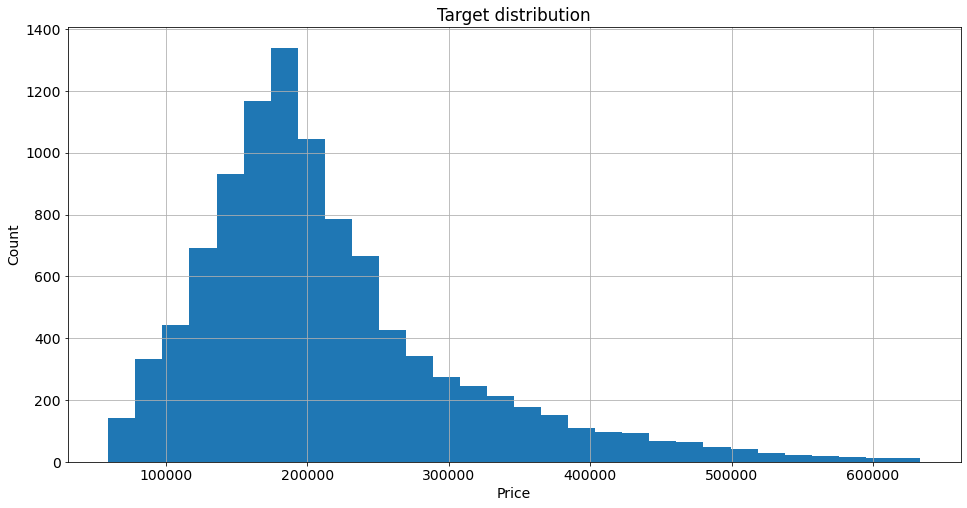

In [12]:
plt.figure(figsize = (16, 8))

train_df['Price'].hist(bins=30)
plt.ylabel('Count')
plt.xlabel('Price')

plt.title('Target distribution')
plt.show()

### Количественные переменные

In [13]:
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


### Номинативные переменные

In [14]:
train_df.select_dtypes(include='object').columns.tolist()

['Id', 'DistrictId', 'Ecology_2', 'Ecology_3', 'Shops_2']

In [15]:
train_df['DistrictId'].value_counts()

27     851
1      652
23     565
6      511
9      294
      ... 
209      1
205      1
199      1
207      1
117      1
Name: DistrictId, Length: 205, dtype: int64

In [16]:
train_df['Ecology_2'].value_counts()

B    9903
A      97
Name: Ecology_2, dtype: int64

In [17]:
train_df['Ecology_3'].value_counts()

B    9725
A     275
Name: Ecology_3, dtype: int64

In [18]:
train_df['Shops_2'].value_counts()

B    9175
A     825
Name: Shops_2, dtype: int64

## 2. Обработка выбросов

### Rooms

In [19]:
train_df['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

In [20]:
train_df['Rooms_outlier'] = 0
train_df.loc[(train_df['Rooms'] == 0) | (train_df['Rooms'] >= 6), 'Rooms_outlier'] = 1
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,...,B,11,3097,0,NaN,0,0,B,305018.871089,0
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,B,30,6207,1,1183.0,1,0,B,177734.553407,0
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,B,33,5261,0,240.0,3,1,B,282078.720850,0
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,...,B,1,264,0,NaN,0,1,B,168106.007630,0
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,B,33,8667,2,NaN,0,6,B,343995.102962,0


In [21]:
train_df.loc[train_df['Rooms'] == 0, 'Rooms'] = 1
train_df.loc[train_df['Rooms'] >= 6, 'Rooms'] = train_df['Rooms'].median()

In [22]:
train_df['Rooms'].value_counts()

2.0    3884
1.0    3713
3.0    2235
4.0     150
5.0      18
Name: Rooms, dtype: int64

### Square, LifeSquare, KitchenSquare

In [23]:
train_df['Square'].value_counts()

26.553188     1
46.363496     1
100.751999    1
70.726600     1
40.523022     1
             ..
76.481158     1
86.915187     1
82.482521     1
43.112986     1
97.664912     1
Name: Square, Length: 10000, dtype: int64

In [24]:
train_df['LifeSquare'].value_counts()

28.003539    1
19.224066    1
21.613298    1
25.688943    1
44.662105    1
            ..
37.980219    1
17.130385    1
33.273700    1
28.313300    1
28.421652    1
Name: LifeSquare, Length: 7887, dtype: int64

In [25]:
train_df['KitchenSquare'].value_counts()

1.0       2460
8.0       1306
5.0       1169
10.0      1075
6.0       1038
9.0        843
0.0        697
7.0        609
12.0       249
11.0       233
13.0        67
14.0        51
4.0         39
15.0        31
3.0         22
16.0        16
20.0        14
17.0        12
19.0        11
18.0         6
2.0          4
22.0         3
43.0         2
112.0        2
41.0         2
32.0         2
58.0         2
25.0         2
37.0         2
30.0         2
51.0         2
40.0         1
96.0         1
48.0         1
72.0         1
73.0         1
2014.0       1
66.0         1
36.0         1
78.0         1
54.0         1
29.0         1
31.0         1
35.0         1
62.0         1
39.0         1
1970.0       1
60.0         1
75.0         1
26.0         1
21.0         1
84.0         1
63.0         1
123.0        1
53.0         1
42.0         1
23.0         1
27.0         1
Name: KitchenSquare, dtype: int64

In [26]:
train_df['KitchenSquare'].quantile(.975), train_df['KitchenSquare'].quantile(.025)

(13.0, 0.0)

In [27]:
train_df.loc[(train_df['LifeSquare'].notna()) & (train_df['LifeSquare'] > 230)]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier
357,14990,23,2.0,48.449873,263.542020,5.0,6,5.0,1972,0.075779,...,B,6,1437,3,NaN,0,2,B,141780.231857,0
1906,5548,86,5.0,275.645284,233.949309,26.0,12,37.0,2011,0.161976,...,A,31,7010,5,4508.0,3,7,B,455264.882666,0
5183,15886,85,3.0,78.059331,461.463614,10.0,12,16.0,1998,0.037178,...,B,52,11217,1,2300.0,1,7,B,394253.299978,0
7010,2307,102,1.0,409.425181,410.639749,10.0,4,4.0,2016,0.238617,...,B,26,3889,6,705.0,3,6,B,90470.430830,0
8000,16550,27,3.0,81.694417,7480.592129,1.0,9,17.0,2016,0.017647,...,B,2,469,0,NaN,0,0,B,217357.492366,0
9229,11602,30,2.0,641.065193,638.163193,10.0,20,19.0,2019,0.000078,...,B,22,6398,141,1046.0,3,23,B,133529.681562,0


In [28]:
condition_KitchenSquare = (train_df['KitchenSquare'].isna()) \
             | (train_df['KitchenSquare'] > train_df['KitchenSquare'].quantile(.975)) | (train_df['KitchenSquare'] < 4)
        
train_df.loc[condition_KitchenSquare, 'KitchenSquare'] = train_df['KitchenSquare'].median()

In [29]:
condition_LifeSquare = (train_df['LifeSquare'].notna()) & (train_df['LifeSquare'] > 230)
train_df.loc[condition_LifeSquare, 'LifeSquare'] = train_df['LifeSquare'].median()
        
condition_LifeSquare_Square = (train_df['LifeSquare'].notna()) & (train_df['LifeSquare'] > train_df['Square'])
condition_KitchenSquare_Square = train_df['KitchenSquare'] > train_df['Square']
        
train_df['Square_outlier'] = 0
train_df.loc[condition_LifeSquare | condition_KitchenSquare |  
                                    condition_LifeSquare_Square | condition_KitchenSquare_Square, 'Square_outlier'] = 1

In [30]:
train_df['KitchenSquare'].value_counts()

6.0     4410
8.0     1306
5.0     1169
10.0    1075
9.0      843
7.0      609
12.0     249
11.0     233
13.0      67
4.0       39
Name: KitchenSquare, dtype: int64

### HouseFloor, Floor

In [31]:
train_df['HouseFloor'].sort_values().unique()

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        36.,  37.,  38.,  39.,  40.,  44.,  45.,  47.,  48.,  99., 117.])

In [32]:
train_df['Floor'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 37, 42],
      dtype=int64)

In [33]:
((train_df['Floor'] > train_df['HouseFloor']) | (train_df['HouseFloor'] == 0)).sum()

1825

In [34]:
train_df['HouseFloor_outlier'] = 0
train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
train_df.loc[train_df['Floor'] > train_df['HouseFloor'], 'HouseFloor_outlier'] = 1

In [35]:
train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor'] = 1

In [36]:
condition_Floor_HouseFloor = (train_df['Floor'] > train_df['HouseFloor'])
train_df.loc[condition_Floor_HouseFloor, ['Floor', \
                    'HouseFloor']] = train_df.loc[condition_Floor_HouseFloor, ['HouseFloor','Floor']].values

In [37]:
(train_df['Floor'] > train_df['HouseFloor']).sum()

0

### HouseYear

In [38]:
train_df['HouseYear'].sort_values(ascending=False)

9163    20052011
8828        4968
7246        2020
2350        2020
8296        2020
          ...   
7610        1916
6250        1914
2066        1912
2795        1912
6794        1910
Name: HouseYear, Length: 10000, dtype: int64

In [39]:
train_df['HouseYear_outlier'] = 0
train_df.loc[(train_df['HouseYear'] > datetime.now().year) | (train_df['HouseYear'] < 1900), 'HouseYear_outlier'] = 1

In [40]:
train_df.loc[(train_df['HouseYear'] > 5000), 'HouseYear'] = 2011
train_df.loc[(train_df['HouseYear'] > 2020) & (train_df['HouseYear'] < 5000), 'HouseYear'] = 1968

In [41]:
train_df['HouseYear'].sort_values(ascending=False)

8664    2020
7207    2020
7721    2020
5641    2020
1004    2020
        ... 
7610    1916
6250    1914
2066    1912
2795    1912
6794    1910
Name: HouseYear, Length: 10000, dtype: int64

## 3. Обработка пропусков

In [42]:
train_df.isna().sum()

Id                       0
DistrictId               0
Rooms                    0
Square                   0
LifeSquare            2113
KitchenSquare            0
Floor                    0
HouseFloor               0
HouseYear                0
Ecology_1                0
Ecology_2                0
Ecology_3                0
Social_1                 0
Social_2                 0
Social_3                 0
Healthcare_1          4798
Helthcare_2              0
Shops_1                  0
Shops_2                  0
Price                    0
Rooms_outlier            0
Square_outlier           0
HouseFloor_outlier       0
HouseYear_outlier        0
dtype: int64

In [43]:
train_df[['Square', 'LifeSquare', 'KitchenSquare']].head(10)

,Square,LifeSquare,KitchenSquare
0,115.027311,NaN,10.0
1,39.832524,23.169223,8.0
2,78.342215,47.671972,10.0
3,40.409907,NaN,6.0
4,64.285067,38.562517,9.0
5,62.528465,47.103833,6.0
6,33.938750,21.772930,9.0
7,50.391814,32.893256,8.0
8,46.887892,44.628132,6.0
9,79.867477,75.085125,6.0


### LifeSquare

In [44]:
BathroomSquare_coefficient = (train_df['Square'].median() - train_df['LifeSquare'].median() \
            - train_df['KitchenSquare'].median()) / train_df['Square'].median()

train_df['LifeSquare_nan'] = train_df['LifeSquare'].isna() * 1
condition_LifeSquare_nan = train_df['LifeSquare'].isna()
        
train_df.loc[condition_LifeSquare_nan, 'LifeSquare'] = train_df.loc[condition_LifeSquare_nan, \
        'Square'] - train_df.loc[condition_LifeSquare_nan, \
            'KitchenSquare'] - BathroomSquare_coefficient * train_df.loc[condition_LifeSquare_nan, 'Square']

### Healthcare_1

In [45]:
train_df.drop('Healthcare_1', axis=1, inplace=True)

In [46]:
class DataPreprocessing:
    """Подготовка исходных данных"""

    def __init__(self):
        """Параметры класса"""
        self.medians=None
        self.kitchenSquare_quantile_975 = None
        self.BathroomSquare_coefficient = None
        self.current_year = None
        
    def fit(self, X):
        """Сохранение статистик"""       
        # Расчет медиан
        self.medians = X.median()
        self.KitchenSquare_quantile_975 = X['KitchenSquare'].quantile(.975)
        
        # Расчет коэффициента
        self.BathroomSquare_coefficient = (self.medians['Square'] - self.medians['LifeSquare'] \
            - self.medians['KitchenSquare']) / self.medians['Square']
        
        # Текущий год
        self.current_year = datetime.now().year
        
    def transform(self, X):
        """Трансформация данных"""

        # Rooms
        X['Rooms_outlier'] = 0
        X.loc[(X['Rooms'] == 0) | (X['Rooms'] >= 6), 'Rooms_outlier'] = 1
        
        X.loc[X['Rooms'] == 0, 'Rooms'] = 1
        X.loc[X['Rooms'] >= 6, 'Rooms'] = self.medians['Rooms']
        
        # Square, LifeSquare, KitchenSquare
        condition_KitchenSquare = (X['KitchenSquare'].isna()) | (X['KitchenSquare'] > self.KitchenSquare_quantile_975) \
                            | (X['KitchenSquare'] < 4)
        X.loc[condition_KitchenSquare, 'KitchenSquare'] = self.medians['KitchenSquare']
        
        condition_LifeSquare = (X['LifeSquare'].notna()) & (X['LifeSquare'] > 230)
        X.loc[condition_LifeSquare, 'LifeSquare'] = self.medians['LifeSquare']
        
        condition_LifeSquare_Square = (X['LifeSquare'].notna()) & (X['LifeSquare'] > X['Square'])
        condition_KitchenSquare_Square = X['KitchenSquare'] > X['Square']
        
        X['Square_outlier'] = 0
        X.loc[condition_LifeSquare | condition_KitchenSquare |  
              condition_LifeSquare_Square | condition_KitchenSquare_Square, 'Square_outlier'] = 1
        
        # HouseFloor, Floor
        X['HouseFloor_outlier'] = 0
        X.loc[X['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
        X.loc[X['Floor'] > X['HouseFloor'], 'HouseFloor_outlier'] = 1
        
        X.loc[X['HouseFloor'] == 0, 'HouseFloor'] = 1

        condition_Floor_HouseFloor = (X['Floor'] > X['HouseFloor'])
        X.loc[condition_Floor_HouseFloor, ['Floor', \
            'HouseFloor']] = X.loc[condition_Floor_HouseFloor, ['HouseFloor','Floor']].values
        
        # HouseYear
        X['HouseYear_outlier'] = 0
        X.loc[(X['HouseYear'] > self.current_year) | (X['HouseYear'] < 1900), 'HouseYear_outlier'] = 1
        
        X.loc[(X['HouseYear'] > 5000), 'HouseYear'] = 2011
        X.loc[(X['HouseYear'] > 2020) & (X['HouseYear'] < 5000), 'HouseYear'] = 1968
        
        # Healthcare_1
        X.drop('Healthcare_1', axis=1, inplace=True)
            
        # LifeSquare
        X['LifeSquare_nan'] = X['LifeSquare'].isna() * 1
        condition_LifeSquare_nan = X['LifeSquare'].isna()
        
        X.loc[condition_LifeSquare_nan, 'LifeSquare'] = X.loc[condition_LifeSquare_nan, \
            'Square'] - X.loc[condition_LifeSquare_nan, \
            'KitchenSquare'] - self.BathroomSquare_coefficient * X.loc[condition_LifeSquare_nan, 'Square']
        
        
        X.fillna(self.medians, inplace=True)
        
        return X

## 4. Построение новых признаков

### Dummies

In [47]:
binary_to_numbers = {'A': 0, 'B': 1}

train_df['Ecology_2'] = train_df['Ecology_2'].map(binary_to_numbers)
train_df['Ecology_3'] = train_df['Ecology_3'].map(binary_to_numbers)
train_df['Shops_2'] = train_df['Shops_2'].map(binary_to_numbers)

### DistrictSize

In [48]:
district_size = train_df['DistrictId'].value_counts().reset_index() \
                    .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})

district_size.head()

,DistrictId,DistrictSize
0,27,851
1,1,652
2,23,565
3,6,511
4,9,294


In [49]:
train_df = train_df.merge(district_size, on='DistrictId', how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,Square_outlier,HouseFloor_outlier,HouseYear_outlier,LifeSquare_nan,DistrictSize
0,11809,27,3.0,115.027311,74.948065,10.0,4.0,10.0,2014,0.075424,...,0,0,1,305018.871089,0,0,0,0,1,851
1,3013,22,1.0,39.832524,23.169223,8.0,7.0,8.0,1966,0.118537,...,1,0,1,177734.553407,0,0,0,0,0,78
2,8215,1,3.0,78.342215,47.671972,10.0,2.0,17.0,1988,0.025609,...,3,1,1,282078.720850,0,0,0,0,0,652
3,2352,1,1.0,40.409907,23.842855,6.0,10.0,22.0,1977,0.007122,...,0,1,1,168106.007630,0,1,0,0,1,652
4,13866,94,2.0,64.285067,38.562517,9.0,16.0,16.0,1972,0.282798,...,0,6,1,343995.102962,0,0,0,0,0,89


In [50]:
train_df['DistrictSize'].fillna((train_df['DistrictSize'].isna() * 1).sum(), inplace=True)

### Target encoding

#### District

In [51]:
med_price_by_district = train_df.groupby(['DistrictId'], as_index=False).agg({'Price':'median'})\
                                                                        .rename(columns={'Price':'MedPriceByDistrict'}) 
train_df = train_df.merge(med_price_by_district, on=['DistrictId'], how='left')

In [52]:
med_price_by_district_median = med_price_by_district['MedPriceByDistrict'].median()
train_df['MedPriceByDistrict'].fillna(med_price_by_district_median, inplace=True)

In [53]:
train_df[['DistrictId', 'MedPriceByDistrict']].head()

,DistrictId,MedPriceByDistrict
0,27,146171.433190
1,22,183678.134031
2,1,183663.443595
3,1,183663.443595
4,94,181706.718894


#### Social_1

In [54]:
med_price_by_social_1 = train_df.groupby(['Social_1'], as_index=False).agg({'Price':'median'})\
                                                                        .rename(columns={'Price':'MedPriceBySocial_1'}) 
train_df = train_df.merge(med_price_by_social_1, on=['Social_1'], how='left')

In [55]:
med_price_by_social_1_median = med_price_by_social_1['MedPriceBySocial_1'].median()
train_df['MedPriceBySocial_1'].fillna(med_price_by_social_1_median, inplace=True)

In [56]:
train_df[['Social_1', 'MedPriceBySocial_1']].head()

,Social_1,MedPriceBySocial_1
0,11,163954.539685
1,30,194439.949690
2,33,219892.974797
3,1,175732.068626
4,33,219892.974797


#### Social_2

In [57]:
med_price_by_social_2 = train_df.groupby(['Social_2'], as_index=False).agg({'Price':'median'})\
                                                                        .rename(columns={'Price':'MedPriceBySocial_2'}) 
train_df = train_df.merge(med_price_by_social_2, on=['Social_2'], how='left')

In [58]:
med_price_by_social_2_median = med_price_by_social_2['MedPriceBySocial_2'].median()
train_df['MedPriceBySocial_2'].fillna(med_price_by_social_2_median, inplace=True)

In [59]:
train_df[['Social_2', 'MedPriceBySocial_2']].head()

,Social_2,MedPriceBySocial_2
0,3097,148315.419074
1,6207,186809.604691
2,5261,205993.377137
3,264,183882.806975
4,8667,203153.518639


#### Social_3

In [60]:
med_price_by_social_3 = train_df.groupby(['Social_3'], as_index=False).agg({'Price':'median'})\
                                                                        .rename(columns={'Price':'MedPriceBySocial_3'}) 
train_df = train_df.merge(med_price_by_social_3, on=['Social_3'], how='left')

In [61]:
med_price_by_social_3_median = med_price_by_social_3['MedPriceBySocial_3'].median()
train_df['MedPriceBySocial_3'].fillna(med_price_by_social_3_median, inplace=True)

In [62]:
train_df[['Social_3', 'MedPriceBySocial_3']].head()

,Social_3,MedPriceBySocial_3
0,0,171565.833888
1,1,180928.263574
2,0,171565.833888
3,0,171565.833888
4,2,218458.396218


### KMeans_Clusters

In [63]:
scaler = StandardScaler(with_mean = False)
kmeans = KMeans(n_clusters=2, max_iter=400, random_state=42)

In [64]:
train_df_scaler = scaler.fit_transform(train_df)
train_df['KMeans_Clusters'] = kmeans.fit_predict(train_df)

In [65]:
train_df['KMeans_Clusters'].head()

0    1
1    1
2    1
3    1
4    0
Name: KMeans_Clusters, dtype: int32

In [66]:
class FeatureGenetator():
    """Генерация новых признаков"""
    
    def __init__(self):
        self.binary_to_numbers = None
        self.district_size = None
        self.med_price_by_district = None
        self.med_price_by_district_median = None
        self.med_price_by_social_1 = None
        self.med_price_by_social_1_median = None
        self.scaler = None
        self.kmeans = None
        self.df_scaler = None
        
    def fit(self, X, y=None):
        
        df = X.copy()
        
        # Binary features
        self.binary_to_numbers = {'A': 0, 'B': 1}
        
        # DistrictSize
        self.district_size = df['DistrictId'].value_counts().reset_index() \
                               .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
        
        # Target encoding 
        X_cp = X.copy()
        
        X_cp['Price'] = y.values
        
        X_cp['Ecology_2'] = X_cp['Ecology_2'].map(self.binary_to_numbers)
        X_cp['Ecology_3'] = X_cp['Ecology_3'].map(self.binary_to_numbers)
        X_cp['Shops_2'] = X_cp['Shops_2'].map(self.binary_to_numbers)
        
        ## District
        if y is not None:
            self.med_price_by_district = X_cp.groupby(['DistrictId'], as_index=False).agg({'Price':'median'})\
                                            .rename(columns={'Price':'MedPriceByDistrict'})   
            self.med_price_by_district_median = self.med_price_by_district['MedPriceByDistrict'].median()
         
        ## Social_1
        if y is not None:
            self.med_price_by_social_1 = X_cp.groupby(['Social_1'], as_index=False).agg({'Price':'median'})\
                                            .rename(columns={'Price':'MedPriceBySocial_1'})   
            self.med_price_by_social_1_median = self.med_price_by_social_1['MedPriceBySocial_1'].median()
        
        ## Social_2
        if y is not None:
            self.med_price_by_social_2 = X_cp.groupby(['Social_2'], as_index=False).agg({'Price':'median'})\
                                            .rename(columns={'Price':'MedPriceBySocial_2'})   
            self.med_price_by_social_2_median = self.med_price_by_social_2['MedPriceBySocial_2'].median()
        
        ## Social_3
        if y is not None:
            self.med_price_by_social_3 = X_cp.groupby(['Social_3'], as_index=False).agg({'Price':'median'})\
                                            .rename(columns={'Price':'MedPriceBySocial_3'})   
            self.med_price_by_social_3_median = self.med_price_by_social_3['MedPriceBySocial_3'].median()
            
        # KMeans_Clusters
        df['Ecology_2'] = df['Ecology_2'].map(self.binary_to_numbers)
        df['Ecology_3'] = df['Ecology_3'].map(self.binary_to_numbers)
        df['Shops_2'] = df['Shops_2'].map(self.binary_to_numbers)
        
        df = df.merge(self.district_size, on='DistrictId', how='left')
        
        df['DistrictSize'].fillna((df['DistrictSize'].isna() * 1).sum(), inplace=True)
        
        if self.med_price_by_district is not None:
            df = df.merge(self.med_price_by_district, on=['DistrictId'], how='left')
            df['MedPriceByDistrict'].fillna(self.med_price_by_district_median, inplace=True)
        
        if self.med_price_by_social_1 is not None:
            df = df.merge(self.med_price_by_social_1, on=['Social_1'], how='left')
            df['MedPriceBySocial_1'].fillna(self.med_price_by_social_1_median, inplace=True)
            
        if self.med_price_by_social_2 is not None:
            df = df.merge(self.med_price_by_social_2, on=['Social_2'], how='left')
            df['MedPriceBySocial_2'].fillna(self.med_price_by_social_2_median, inplace=True)
            
        if self.med_price_by_social_3 is not None:
            df = df.merge(self.med_price_by_social_3, on=['Social_3'], how='left')
            df['MedPriceBySocial_3'].fillna(self.med_price_by_social_3_median, inplace=True)
        
        self.scaler = StandardScaler(with_mean = False)
        self.kmeans = KMeans(n_clusters=2, max_iter=400, random_state=42)
        
        self.df_scaler = self.scaler.fit_transform(df)
        self.kmeans.fit(self.df_scaler)

    def transform(self, X):
        
        # Binary features
        X['Ecology_2'] = X['Ecology_2'].map(self.binary_to_numbers)
        X['Ecology_3'] = X['Ecology_3'].map(self.binary_to_numbers)
        X['Shops_2'] = X['Shops_2'].map(self.binary_to_numbers)
        
        # DistrictSize
        X = X.merge(self.district_size, on='DistrictId', how='left')
        X['DistrictSize'].fillna((X['DistrictSize'].isna() * 1).sum(), inplace=True)
        
        # Target encoding 
        ## District
        if self.med_price_by_district is not None:
            X = X.merge(self.med_price_by_district, on=['DistrictId'], how='left')
            X['MedPriceByDistrict'].fillna(self.med_price_by_district_median, inplace=True)
        
        ## Social_1
        if self.med_price_by_social_1 is not None:
            X = X.merge(self.med_price_by_social_1, on=['Social_1'], how='left')
            X['MedPriceBySocial_1'].fillna(self.med_price_by_social_1_median, inplace=True)
        
        ## Social_2
        if self.med_price_by_social_2 is not None:
            X = X.merge(self.med_price_by_social_2, on=['Social_2'], how='left')
            X['MedPriceBySocial_2'].fillna(self.med_price_by_social_2_median, inplace=True)
        
        ## Social_3
        if self.med_price_by_social_3 is not None:
            X = X.merge(self.med_price_by_social_3, on=['Social_3'], how='left')
            X['MedPriceBySocial_3'].fillna(self.med_price_by_social_3_median, inplace=True)
        
        # KMeans_Clusters   
        X_scaler = self.scaler.transform(X)
        X['KMeans_Clusters'] = self.kmeans.predict(X_scaler)
            
        return X

## 5. Отбор признаков

In [67]:
train_df.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'Rooms_outlier',
 'Square_outlier',
 'HouseFloor_outlier',
 'HouseYear_outlier',
 'LifeSquare_nan',
 'DistrictSize',
 'MedPriceByDistrict',
 'MedPriceBySocial_1',
 'MedPriceBySocial_2',
 'MedPriceBySocial_3',
 'KMeans_Clusters']

In [68]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2', 'Social_3',
                 'Helthcare_2', 'Shops_1', 'Shops_2']

new_feature_names = ['Rooms_outlier', 'Square_outlier', 'HouseFloor_outlier', 'LifeSquare_nan', 'DistrictSize', 
                     'MedPriceByDistrict', 'MedPriceBySocial_1', 'MedPriceBySocial_2', 'MedPriceBySocial_3', 'KMeans_Clusters']

target_name = 'Price'

In [69]:
train_df.isna().sum().sum()

0

## 6. Разбиение на train и test

In [70]:
train_df = pd.read_csv("train.csv")

X = train_df.drop(columns=target_name)
y = train_df[target_name]

In [71]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=12)

In [72]:
preprocessor = DataPreprocessing()
preprocessor.fit(X_train)

X_train = preprocessor.transform(X_train)
X_valid = preprocessor.transform(X_valid)

X_train.shape, X_valid.shape

((6700, 23), (3300, 23))

In [73]:
features_gen = FeatureGenetator()
features_gen.fit(X_train, y_train)

X_train = features_gen.transform(X_train)
X_valid = features_gen.transform(X_valid)

X_train.shape, X_valid.shape

((6700, 29), (3300, 29))

In [74]:
X_train = X_train[feature_names + new_feature_names]
X_valid = X_valid[feature_names + new_feature_names]

X_train.shape, X_valid.shape

((6700, 26), (3300, 26))

In [75]:
X_train.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,...,Rooms_outlier,Square_outlier,HouseFloor_outlier,LifeSquare_nan,DistrictSize,MedPriceByDistrict,MedPriceBySocial_1,MedPriceBySocial_2,MedPriceBySocial_3,KMeans_Clusters
count,6700.000000,6700.000000,6700.000000,6700.000000,6700.000000,6700.000000,6700.000000,6700.000000,6700.000000,6700.000000,...,6700.000000,6700.000000,6700.000000,6700.000000,6700.00000,6700.000000,6700.000000,6700.000000,6700.000000,6700.000000
mean,1.884925,56.403762,36.622520,7.140746,7.757015,13.461045,1984.854478,0.118941,0.991493,0.972836,...,0.001343,0.356119,0.182985,0.214030,165.90209,201437.042186,195538.688150,200878.831493,197566.564401,0.684328
std,0.811387,21.993676,17.844746,1.827878,5.265179,6.180120,18.398003,0.119254,0.091850,0.162574,...,0.036629,0.478887,0.386683,0.410178,185.83007,54848.306880,34193.321550,52362.893971,34138.229819,0.464817
min,1.000000,1.136859,0.370619,4.000000,1.000000,1.000000,1910.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.00000,113250.426500,93723.449718,91864.344467,167252.391078,0.000000
25%,1.000000,41.677232,23.774803,6.000000,4.000000,9.000000,1974.000000,0.017647,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,34.00000,168736.170661,179465.764980,167252.391078,172267.847132,0.000000
50%,2.000000,52.542964,33.343578,6.000000,7.000000,14.000000,1977.000000,0.075424,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,69.00000,187957.837368,193036.568150,189161.708884,179295.118607,1.000000
75%,2.000000,65.889256,45.074008,8.000000,11.000000,17.000000,2001.000000,0.195781,1.000000,1.000000,...,0.000000,1.000000,0.000000,0.000000,338.00000,221402.820491,217853.281351,225960.476006,225960.476006,1.000000
max,5.000000,641.065193,441.484940,12.000000,37.000000,117.000000,2020.000000,0.521867,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,592.00000,537979.657509,300164.349724,491156.563182,491156.563182,1.000000


In [76]:
X_train.isna().sum().sum(), X_valid.isna().sum().sum()

(0, 0)

## 7. Построение модели

### Обучение

In [77]:
gb_model = XGBRegressor(max_delta_step=1000000,
             num_parallel_tree=1,
             colsample_bytree=0.4, 
             learning_rate=0.08,
             max_depth=5,
             n_estimators=317, 
             reg_lambda=0.2,
             subsample=0.61, seed=42)

gb_model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.4, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.08, max_delta_step=1000000, max_depth=5,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=317, n_jobs=8, num_parallel_tree=1, random_state=42,
             reg_alpha=0, reg_lambda=0.2, scale_pos_weight=1, seed=42,
             subsample=0.61, tree_method='exact', validate_parameters=1,
             verbosity=None)

### Оценка модели

Train R2:	0.9202020902
Test R2:	0.745636111


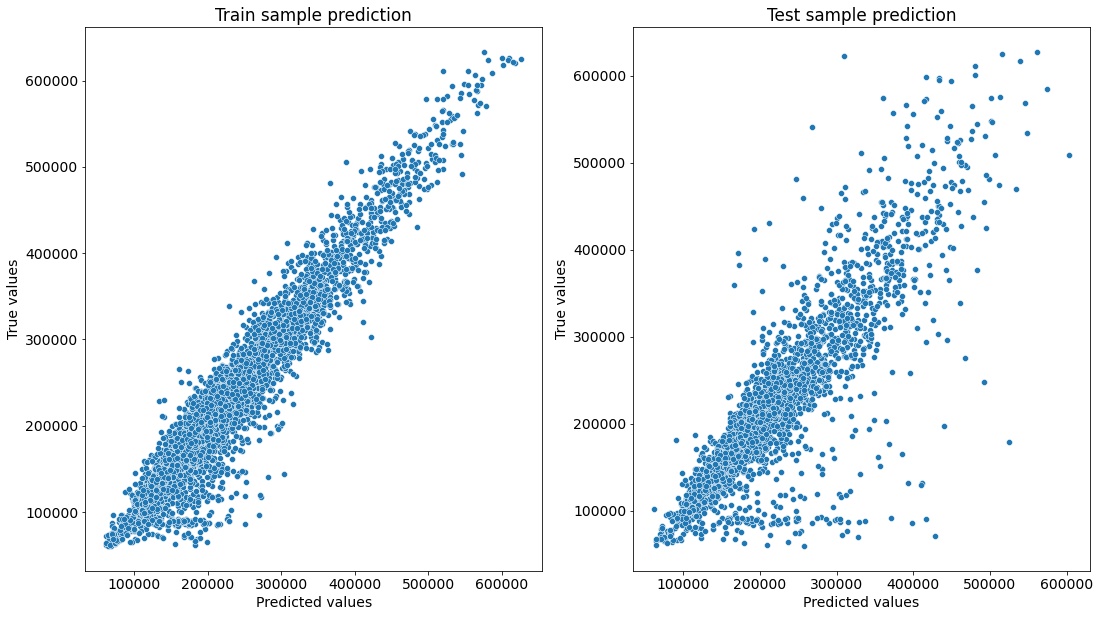

In [78]:
y_train_preds = gb_model.predict(X_train)
y_test_preds = gb_model.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

### Кросс-валидация

In [79]:
cv_score = cross_val_score(gb_model, pd.concat([X_train, X_valid]),  
                           pd.concat([y_train, y_valid]), scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=42))
cv_score

array([0.72411886, 0.7601049 , 0.74558016])

In [80]:
cv_score.mean()

0.7432679732495151

### Важность признаков

In [81]:
feature_importances = pd.DataFrame(zip(X_train.columns, gb_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

In [82]:
feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
25,KMeans_Clusters,0.268812
0,Rooms,0.101856
23,MedPriceBySocial_2,0.083982
21,MedPriceByDistrict,0.078322
1,Square,0.057351
2,LifeSquare,0.039234
22,MedPriceBySocial_1,0.032281
24,MedPriceBySocial_3,0.031842
10,Social_1,0.029746
17,Square_outlier,0.026345


### Bagging

In [83]:
gb = XGBRegressor(max_delta_step=1000000,
             num_parallel_tree=1,
             colsample_bytree=0.4, 
             learning_rate=0.08,
             max_depth=5,
             n_estimators=317, 
             reg_lambda=0.2,
             subsample=0.61, seed=42)

bag = BaggingRegressor(base_estimator=gb, n_estimators=10, random_state=42)
bag.fit(X_train, y_train)

BaggingRegressor(base_estimator=XGBRegressor(base_score=None, booster=None,
                                             colsample_bylevel=None,
                                             colsample_bynode=None,
                                             colsample_bytree=0.4, gamma=None,
                                             gpu_id=None,
                                             importance_type='gain',
                                             interaction_constraints=None,
                                             learning_rate=0.08,
                                             max_delta_step=1000000,
                                             max_depth=5, min_child_weight=None,
                                             missing=nan,
                                             monotone_constraints=None,
                                             n_estimators=317, n_jobs=None,
                                             num_parallel_tree=1,
                   

Train R2:	0.8974124824
Test R2:	0.7517886724


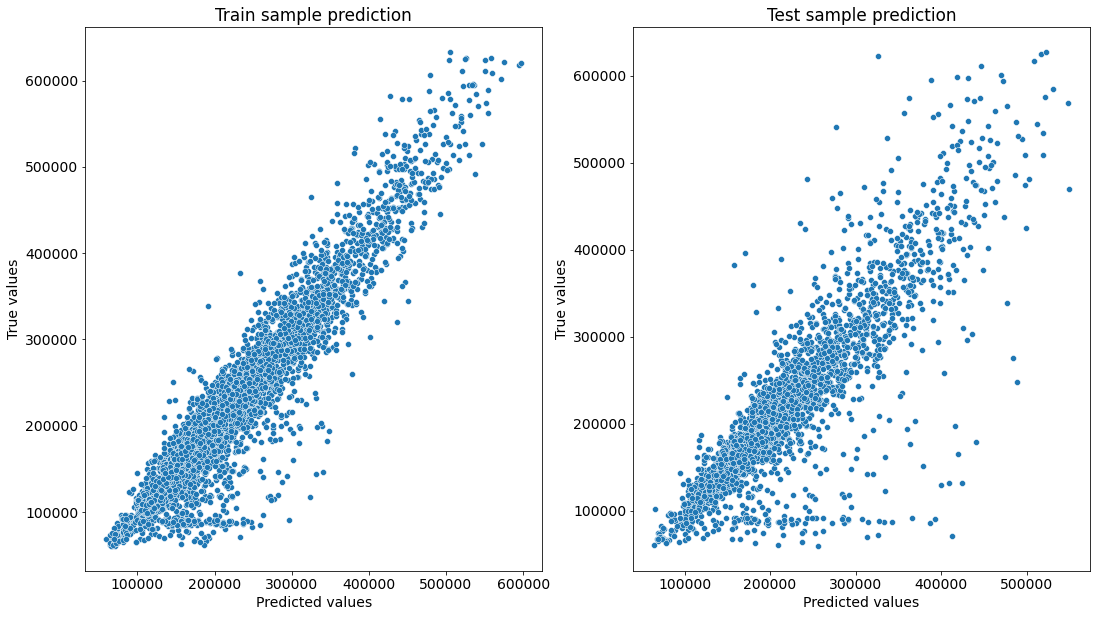

In [84]:
y_train_preds = bag.predict(X_train)
y_test_preds = bag.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

## 8. Прогнозирование на тестовом датасете

### Максимальное бучение на всех данных

In [85]:
test_df = pd.read_csv("test.csv")
test_df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
count,5000.000000,5000.000000,5000.000000,5000.000000,3959.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,2623.000000,5000.00000,5000.000000
mean,8412.595400,51.279200,1.910000,56.449500,36.158810,5.976800,8.632000,12.601000,1984.392600,0.119874,24.933800,5406.900000,8.262600,1146.657263,1.31940,4.242800
std,4832.674037,44.179466,0.838594,19.092787,17.825287,9.950018,5.483228,6.789213,18.573149,0.120070,17.532202,4026.614773,23.863762,1044.744231,1.47994,4.777365
min,1.000000,0.000000,0.000000,1.378543,0.333490,0.000000,1.000000,0.000000,1908.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.00000,0.000000
25%,4221.750000,21.000000,1.000000,41.906231,23.092026,1.000000,4.000000,9.000000,1973.000000,0.019509,6.000000,1564.000000,0.000000,325.000000,0.00000,1.000000
50%,8320.500000,37.000000,2.000000,52.921340,32.925087,6.000000,7.000000,12.000000,1977.000000,0.072158,25.000000,5285.000000,2.000000,900.000000,1.00000,3.000000
75%,12598.250000,77.000000,2.000000,66.285129,45.174091,9.000000,12.000000,17.000000,2000.000000,0.195781,36.000000,7287.000000,5.000000,1548.000000,2.00000,6.000000
max,16795.000000,212.000000,17.000000,223.453689,303.071094,620.000000,78.000000,99.000000,2020.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.00000,23.000000


In [86]:
preprocessor = DataPreprocessing()
preprocessor.fit(X)

X = preprocessor.transform(X)
test_df = preprocessor.transform(test_df)

X.shape, test_df.shape

((10000, 23), (5000, 23))

In [87]:
features_gen = FeatureGenetator()
features_gen.fit(X, y)

X = features_gen.transform(X)
test_df = features_gen.transform(test_df)

X.shape, test_df.shape

((10000, 29), (5000, 29))

In [88]:
X = X[feature_names + new_feature_names]
test_df = test_df[feature_names + new_feature_names]

X.shape, test_df.shape

((10000, 26), (5000, 26))

In [89]:
X.isna().sum().sum(), test_df.isna().sum().sum()

(0, 0)

In [90]:
X.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,...,Rooms_outlier,Square_outlier,HouseFloor_outlier,LifeSquare_nan,DistrictSize,MedPriceByDistrict,MedPriceBySocial_1,MedPriceBySocial_2,MedPriceBySocial_3,KMeans_Clusters
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,...,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,1.887600,56.315775,36.510969,7.193100,7.727300,13.435700,1984.866300,0.118858,0.990300,0.972500,...,0.001200,0.348700,0.182500,0.211300,242.306600,201916.213502,196325.131872,201771.096166,198339.551323,0.690100
std,0.811438,21.058732,17.548242,1.891711,5.267344,6.094012,18.412271,0.119025,0.098015,0.163543,...,0.034622,0.476583,0.386275,0.408251,268.992652,54733.929415,34873.312359,52510.293397,34069.440153,0.462475
min,1.000000,1.136859,0.370619,4.000000,1.000000,1.000000,1910.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,113789.561738,96009.207535,86540.216330,167082.631131,0.000000
25%,1.000000,41.774881,23.693301,6.000000,4.000000,9.000000,1974.000000,0.017647,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,55.000000,168980.370846,175732.068626,168980.370846,171565.833888,0.000000
50%,2.000000,52.513310,33.268327,6.000000,7.000000,14.000000,1977.000000,0.075424,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,104.000000,189439.609358,194439.949690,186809.604691,180928.263574,1.000000
75%,2.000000,65.900625,45.054756,8.000000,11.000000,17.000000,2001.000000,0.195781,1.000000,1.000000,...,0.000000,1.000000,0.000000,0.000000,511.000000,223672.304810,227274.226765,228453.854181,221968.048676,1.000000
max,5.000000,641.065193,440.577442,13.000000,42.000000,117.000000,2020.000000,0.521867,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,851.000000,526438.458919,317648.066012,457744.463369,438061.703276,1.000000


In [91]:
gb = XGBRegressor(max_delta_step=1000000,
             num_parallel_tree=1, # num_parallel_tree=10
             colsample_bytree=0.4, 
             learning_rate=0.08,
             max_depth=5,
             n_estimators=317, 
             reg_lambda=0.2,
             subsample=0.61, seed=42)

bag = BaggingRegressor(base_estimator=gb, n_estimators=10, random_state=42) # n_estimators=100
bag.fit(X, y)

BaggingRegressor(base_estimator=XGBRegressor(base_score=None, booster=None,
                                             colsample_bylevel=None,
                                             colsample_bynode=None,
                                             colsample_bytree=0.4, gamma=None,
                                             gpu_id=None,
                                             importance_type='gain',
                                             interaction_constraints=None,
                                             learning_rate=0.08,
                                             max_delta_step=1000000,
                                             max_depth=5, min_child_weight=None,
                                             missing=nan,
                                             monotone_constraints=None,
                                             n_estimators=317, n_jobs=None,
                                             num_parallel_tree=1,
                   

### Прогнозирование

In [92]:
submit = pd.read_csv('submit.csv')
submit.head()

,Id,Price
0,4567,200000.0
1,5925,200000.0
2,960,200000.0
3,3848,200000.0
4,746,200000.0


In [93]:
predictions = bag.predict(test_df)
predictions

array([165985.78, 123028.7 , 143563.27, ..., 147458.05, 189202.11,
       264240.  ], dtype=float32)

In [94]:
submit['Price'] = predictions
submit.head()

,Id,Price
0,4567,165985.781250
1,5925,123028.703125
2,960,143563.265625
3,3848,116766.273438
4,746,188787.359375


In [95]:
submit.to_csv('bag_xgb_submit.csv', index=False)